In [333]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

In [334]:
train_dat = pd.read_csv("recruiting_zeta-disease_training-data_take-home-challenge - 2021_zeta-disease_training-data_take-home-challenge.csv")
train_dat

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80,0,1.5038,0,10,0
1,23,150,38.5,68,71,0.3868,55,2,0
2,47,186,29.9,90,0,0.2728,0,7,0
3,18,150,30.8,70,1033,0.6598,56,0,0
4,24,160,32.4,74,125,0.7608,59,2,0
...,...,...,...,...,...,...,...,...,...
795,26,161,28.4,90,78,0.5578,42,3,0
796,37,165,33.7,60,0,0.3078,69,6,1
797,27,166,25.6,74,0,0.2638,0,5,0
798,109,139,28.1,66,94,0.2298,53,1,0


Peaking at the data we can see that we have some missing data we need to remove (if you have a blood sugar level, blood pressure, or bmi of 0 you are most likely dead). 

In [335]:
train_dat = train_dat[train_dat.weight != 0]
train_dat = train_dat[train_dat.bmi!= 0]
train_dat = train_dat[train_dat.blood_pressure != 0]
train_dat = train_dat[train_dat.cardio_stress_test != 0]
train_dat = train_dat[train_dat.insulin_test != 0]
train_dat = train_dat[train_dat.liver_stress_test != 0]
train_dat = sm.add_constant(train_dat)

x_train = train_dat.iloc[:,0:9]
y_train = train_dat["zeta_disease"]


[Text(0.5, 0, 'const'),
 Text(1.5, 0, 'age'),
 Text(2.5, 0, 'weight'),
 Text(3.5, 0, 'bmi'),
 Text(4.5, 0, 'blood_pressure'),
 Text(5.5, 0, 'insulin_test'),
 Text(6.5, 0, 'liver_stress_test'),
 Text(7.5, 0, 'cardio_stress_test'),
 Text(8.5, 0, 'years_smoking'),
 Text(9.5, 0, 'zeta_disease')]

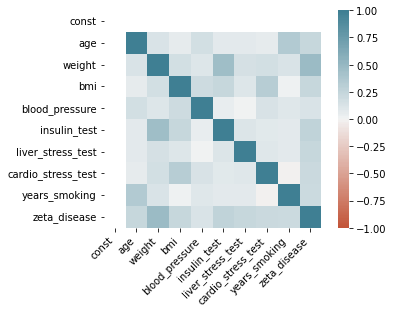

In [336]:
corr = train_dat.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

The initial exploration of the data suggests some moderate correlations with a number of variables, especially weight. Nothing stands out as particularly troublesome as far as covaraince between predictors. The covariance between predictors is low enough that it is very unlikely that interaction terms are going to be useful. A simple logit model may be a pretty good fit given the low number of variables. It also has the advantage of retaining scrutability.

Below I'm going to:
 - Begin with the full model with all variables. I'm using statsmodel instead of sklearn because it gives me easy access to summaries of my model. One note here is that statsmod does true logistic regression, where sklearn uses l2 peanalizatoin by default. So the results may be slightly different.
 - I'll evaluate variables with their z-values and associated p-values and decide which to drop.
 - I will use BIC (Bayesian informatoin criterion) as my main measure of model fit, as it penalizes complex models and keeps over-fitting under control.
 - I could "automate" this process with a function for backward selection, but given the small number of variables, I like to be able to go through them manually and decide if what is happening makes substantive sense. 
 - Prefer backwards selection over forward selection because you quickly see if things aren't working (because p-values and coefficients will change wildely when you drop a variable)

In [337]:
full_mod = sm.Logit(y_train,x_train).fit()
print(full_mod.summary())
print("BIC:",full_mod.bic)


Optimization terminated successfully.
         Current function value: 0.460103
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           zeta_disease   No. Observations:                  429
Model:                          Logit   Df Residuals:                      420
Method:                           MLE   Df Model:                            8
Date:                Sat, 16 Apr 2022   Pseudo R-squ.:                  0.2772
Time:                        10:15:05   Log-Likelihood:                -197.38
converged:                       True   LL-Null:                       -273.06
Covariance Type:            nonrobust   LLR p-value:                 1.020e-28
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -10.5457      1.184     -8.908      0.000     -12.866      -8.225
age  

Liver_stress_test is a poor predictor, as is the insulin_test. We'll remove those

In [338]:
x_train = x_train.drop(["insulin_test","liver_stress_test"],axis=1)

reduced_mod_1 = sm.Logit(y_train,x_train).fit()
print(reduced_mod_1.summary())
print("BIC:",reduced_mod_1.bic)


Optimization terminated successfully.
         Current function value: 0.471738
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           zeta_disease   No. Observations:                  429
Model:                          Logit   Df Residuals:                      422
Method:                           MLE   Df Model:                            6
Date:                Sat, 16 Apr 2022   Pseudo R-squ.:                  0.2589
Time:                        10:15:05   Log-Likelihood:                -202.38
converged:                       True   LL-Null:                       -273.06
Covariance Type:            nonrobust   LLR p-value:                 5.129e-28
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -10.1599      1.135     -8.955      0.000     -12.384      -7.936
age  

This model does improve the BIC, and makes blood_pressure highly insignificant.

In [339]:
x_train = x_train.drop(["blood_pressure"],axis=1)


reduced_mod_2 = sm.Logit(y_train,x_train).fit()
print(reduced_mod_2.summary())
print("BIC:",reduced_mod_2.bic)

Optimization terminated successfully.
         Current function value: 0.471778
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           zeta_disease   No. Observations:                  429
Model:                          Logit   Df Residuals:                      423
Method:                           MLE   Df Model:                            5
Date:                Sat, 16 Apr 2022   Pseudo R-squ.:                  0.2588
Time:                        10:15:05   Log-Likelihood:                -202.39
converged:                       True   LL-Null:                       -273.06
Covariance Type:            nonrobust   LLR p-value:                 9.267e-29
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -10.0752      1.036     -9.722      0.000     -12.106      -8.044
age  

We now see that everything is fairly significant; we may want to check a couple of interaction terms to see if they make a big different. Interactions should really only be included if they "make sense" in my opinion, so I'll only test a couple:

- cardio_stress_test*years_smoking
- age*weight
- weight*bmi

In [340]:
x_train["weight*age"] = x_train["weight"] * x_train["age"]
x_train['cardio*smoking'] = x_train["cardio_stress_test"] * x_train["years_smoking"]
x_train["weight*bmi"] = x_train["weight"] * x_train["bmi"]

reduced_mod_3 = sm.Logit(y_train,x_train).fit()
print(reduced_mod_3.summary())
print("BIC:",reduced_mod_3.bic)

Optimization terminated successfully.
         Current function value: 0.459208
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           zeta_disease   No. Observations:                  429
Model:                          Logit   Df Residuals:                      420
Method:                           MLE   Df Model:                            8
Date:                Sat, 16 Apr 2022   Pseudo R-squ.:                  0.2786
Time:                        10:15:05   Log-Likelihood:                -197.00
converged:                       True   LL-Null:                       -273.06
Covariance Type:            nonrobust   LLR p-value:                 7.051e-29
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -7.4540      3.731     -1.998      0.046     -14.766      -0.142
age  

Weight and age is close, but the other two are clearly not significant, so I'll drop those again.

In [341]:
x_train = x_train.drop(["cardio*smoking"],axis=1)
x_train = x_train.drop(["weight*bmi"],axis=1)
x_train = x_train.drop(["cardio_stress_test"],axis=1)
x_train = x_train.drop(["years_smoking"],axis=1)

final_mod = sm.Logit(y_train,x_train).fit()
print(final_mod.summary())
print("BIC:",final_mod.bic)

Optimization terminated successfully.
         Current function value: 0.466548
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           zeta_disease   No. Observations:                  429
Model:                          Logit   Df Residuals:                      424
Method:                           MLE   Df Model:                            4
Date:                Sat, 16 Apr 2022   Pseudo R-squ.:                  0.2670
Time:                        10:15:05   Log-Likelihood:                -200.15
converged:                       True   LL-Null:                       -273.06
Covariance Type:            nonrobust   LLR p-value:                 1.592e-30
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.3470      1.791     -2.428      0.015      -7.857      -0.837
age           -0.1487      0.

This model makes a lot of sense. Weight is now insignificant because the interaction is significant (but we should always leave base terms from an interaction!). I also removed a couple more variables (smoking and cardio test, that were insignificant. This improved our BIC fairly substantially). I felt this document was getting long so didn't inlude this as a sperate step.

This looks like a good final model. All very significant and the lowest BIC

The code below outputs predictions for the 20 test data points. I'm leaving them in probability format. We could turn these into "hard predictions" based on a cutoff. However, the cutoff to choose is dependant on disease prevalance in the population, allocation of treatement resources etc. An ROC curve would give us some practical emperical informatoin about what a good cutoff may be, but more information from shareholders would be needed to make this decision. 

In [342]:
test_dat = pd.read_csv("recruiting_zeta-disease_prediction-data_take-home-challenge - 2021-01-21_zeta-disease_prediction-data_take-home-challenge.csv")
x_test = test_dat.iloc[:,0:3]
x_test["weight*age"] = x_test["weight"] * x_test["age"]
x_test = sm.add_constant(x_test)
x_test

print("Predictions for our twenty points:")
final_mod.predict(x_test)


Predictions for our twenty points:


0     0.197081
1     0.326439
2     0.107027
3     0.637321
4     0.823151
5     0.059703
6     0.137620
7     0.092008
8     0.520380
9     0.197771
10    0.899786
11    0.639679
12    0.274721
13    0.781897
14    0.403336
15    0.811077
16    0.521914
17    0.750861
18    0.365160
19    0.570245
dtype: float64